## Loading and Preprocessing Data

In [211]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [212]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahulsah06/gooogle-stock-price")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\edvard.smoliakov\.cache\kagglehub\datasets\rahulsah06\gooogle-stock-price\versions\1


In [213]:
# Importing the training set
dataset_train = pd.read_csv(path+"/Google_Stock_Price_Train.csv")

In [214]:
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [215]:
"Extracting only the Open price. Converting to a NumPy array. Shape becomes (number_of_days, 1)"
train = dataset_train.loc[:, ["Open"]].values
train

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]], shape=(1258, 1))

In [216]:
# Feature Scaling
"RNNs work better when inputs are in a small numerical range. Stock prices vary widely → scaling stabilizes training. Scales values to [0, 1]. "
"fit_transform learns min/max from training data and scales it"

from sklearn.preprocessing import MinMaxScaler
features = ['Open', 'High', 'Low']
for feat in features:
    dataset_train[feat] = dataset_train[feat].astype(str).str.replace(',', '')
    dataset_train[feat] = dataset_train[feat].astype(float)
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(dataset_train[features].values)
train_scaled

array([[0.08581368, 0.09640129, 0.09044931],
       [0.09701243, 0.09834351, 0.09823458],
       [0.09433366, 0.09251685, 0.09408623],
       ...,
       [0.95725128, 0.95807422, 0.95844067],
       [0.93796041, 0.94257381, 0.95033338],
       [0.93688146, 0.93669113, 0.93421352]], shape=(1258, 3))

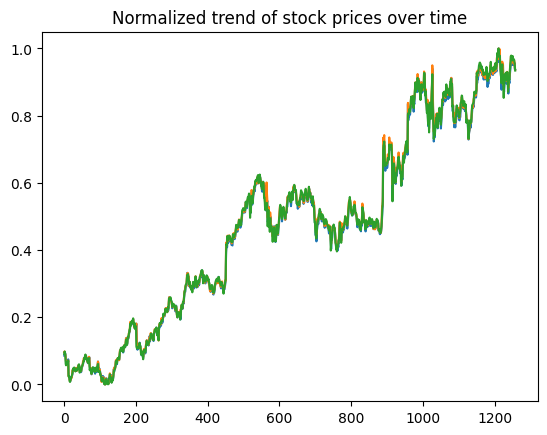

In [217]:
plt.plot(train_scaled)
plt.title("Normalized trend of stock prices over time")
plt.show()

In [218]:
# Creating a data structure with 50 timesteps and 1 output
X_train = []
y_train = []
timesteps = 50 # Each prediction uses the previous 50 days to predict the next day

for i in range(timesteps, len(train_scaled)):
    X_train.append(train_scaled[i-timesteps:i, :]) # sequences of 50 previous stock prices
    y_train.append(train_scaled[i, 0])             # the stock price immediately after those 50 days

X_train, y_train = np.array(X_train), np.array(y_train)

In [219]:
# Reshaping (for RNN input)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))
X_train # is in shape of (samples, timesteps, features) -> (number of training examples, 50, 1 feature=open price)

array([[[0.08581368, 0.09640129, 0.09044931],
        [0.09701243, 0.09834351, 0.09823458],
        [0.09433366, 0.09251685, 0.09408623],
        ...,
        [0.03675869, 0.03951669, 0.04032808],
        [0.04486941, 0.04960128, 0.04625701],
        [0.05065481, 0.05419538, 0.05372026]],

       [[0.09701243, 0.09834351, 0.09823458],
        [0.09433366, 0.09251685, 0.09408623],
        [0.09156187, 0.08881917, 0.08800576],
        ...,
        [0.04486941, 0.04960128, 0.04625701],
        [0.05065481, 0.05419538, 0.05372026],
        [0.05214302, 0.05486769, 0.05502728]],

       [[0.09433366, 0.09251685, 0.09408623],
        [0.09156187, 0.08881917, 0.08800576],
        [0.07984225, 0.07671765, 0.06106986],
        ...,
        [0.05065481, 0.05419538, 0.05372026],
        [0.05214302, 0.05486769, 0.05502728],
        [0.05612397, 0.05710871, 0.05995227]],

       ...,

       [[0.9313937 , 0.94242441, 0.94764358],
        [0.94636878, 0.9718565 , 0.96292999],
        [0.96569685, 0

In [220]:
y_train

array([0.05214302, 0.05612397, 0.05818885, ..., 0.95725128, 0.93796041,
       0.93688146], shape=(1208,))

## Create RNN Model

In [221]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout


# Initialising the RNN
regressor = Sequential()

# 1st RNN layer with some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (50, 3)))
regressor.add(Dropout(0.2))

# 2nd RNN layer with some Dropout regularisation. Units = neurons. return_sequences needed as another RNN follows
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# 3rd RNN layer with some Dropout regularisation. Deep RNN structure improves pattern learning over time
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# A final 4th RNN layer with some Dropout regularisation. return_sequences is false as outputs only the last timestep
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# Output layer - predicts next day's stock price
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - loss: 0.3797
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.2674
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.2035
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1550
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.1330
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0918
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0773
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0708
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0641
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0517
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0468
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0389
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0353
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0334
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - l

## Predictions and Visualising RNN Model

In [222]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv(path+'/Google_Stock_Price_Test.csv')
for feat in features:
    dataset_test[feat] = dataset_test[feat].astype(str).str.replace(',', '')
    dataset_test[feat] = dataset_test[feat].astype(float)
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [223]:
# Ground truth for comparison
real_stock_price = dataset_test.loc[:, ["Open"]].values
real_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

In [224]:
# Getting the predicted stock price of 2017. 
"Predictions for day t need the previous 50 days. Some of those days come from training data"

dataset_total = pd.concat([dataset_train[features], dataset_test[features]], axis=0)
inputs = scaler.transform(dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values)
inputs


array([[0.97510976, 0.97626384, 0.9827436 ],
       [0.95966962, 0.96791604, 0.97889832],
       [0.97808617, 0.99719872, 0.99939385],
       [1.        , 1.        , 1.        ],
       [0.98076494, 0.98188507, 0.98329292],
       [0.97083116, 0.97536743, 0.97416275],
       [0.98450406, 0.99777765, 0.97812169],
       [0.96054394, 0.96298579, 0.95995605],
       [0.9371419 , 0.94922218, 0.9439309 ],
       [0.92841729, 0.93458084, 0.9210297 ],
       [0.90804747, 0.91273087, 0.91265722],
       [0.8771858 , 0.91349655, 0.89661312],
       [0.92153434, 0.94119185, 0.93826716],
       [0.93809063, 0.96068874, 0.95273905],
       [0.93165414, 0.95247166, 0.93660024],
       [0.95254483, 0.95235961, 0.89968177],
       [0.88812412, 0.89560573, 0.89627216],
       [0.88637547, 0.8901339 , 0.85300803],
       [0.87032145, 0.9024035 , 0.88981285],
       [0.88563137, 0.90602648, 0.89651841],
       [0.90743359, 0.91786655, 0.9225072 ],
       [0.91571173, 0.92216184, 0.91449462],
       [0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


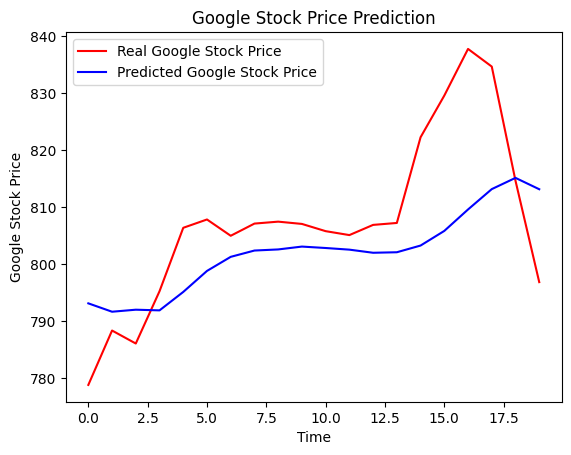

In [225]:
# Creates sliding windows just like training data. 70 corresponds to number of test days.
X_test = []
for i in range(timesteps, 70):
    X_test.append(inputs[i-timesteps:i, :]) # 4 features

# Reshaped for RNN input. 
X_test = np.array(X_test)
predicted_stock_price = regressor.predict(X_test)

scaler_open = MinMaxScaler()
scaler_open.fit(dataset_train[['Open']].values)

# Predictions are scaled back to original price values
predicted_stock_price = scaler_open.inverse_transform(predicted_stock_price)

# Visualising the results -> how well the model follows the real trend?
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


## Assignment
Try to improve the result! Document your actions and conclusions further in this notebook.

#### License
This Notebook has been released under the Apache 2.0 open source license.

https://www.kaggle.com/code/moonglow22/rnn-and-lstm-tutorial-for-beginners/notebook

# Improving
Original RMSE: 25.228745586081462
1) Change: Updated the RNN to use multiple features (Open, High, Low) instead of only Open price
 1) RMSE: 12.10510967298024

Note: LSTM would work best on this dataset, because LSTM does not forget the past data. SimpleRNN loses dependencies after ~30 timesteps.

In [226]:
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print("RMSE:", rmse)

RMSE: 12.37534155959342
